Related urls, will remove once finished:
- https://www.kaggle.com/code/mjmurphy28/grid-search-for-sarima

Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima import auto_arima

Load dataset and prepare df

In [2]:
# Load the dataset
file_path = '../data/WHO-COVID-19-global-df.csv'
date_column = 'Date_reported'
target_column = 'New_deaths'
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()

Train test split

In [ ]:
train = df.iloc[:-30]
test = df.iloc[-30:]

Parameter tuning for order and seasonal order

In [5]:
stepwise_fit = auto_arima(df[target_column], trace=True,
suppress_warnings=True, max_P=3, max_D=2, max_Q=3, m=12, stepwise=True)
best_order=stepwise_fit.order
best_seasonal_order=stepwise_fit.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=25596.367, Time=12.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=26672.005, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=26167.798, Time=0.81 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=25765.898, Time=2.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=26670.005, Time=0.09 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=25619.432, Time=9.68 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=25655.092, Time=13.09 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=26559.857, Time=19.73 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=24.24 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=25528.870, Time=1.40 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=25718.319, Time=1.19 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=25803.620, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=25555.335, Time=1.55 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=25579.550, Time=1.13 sec
 ARIMA(

Create Model

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train[target_column],order=best_order, seasonal_order=best_seasonal_order)
model=model.fit()
model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19215D+00    |proj g|=  1.98194D-01


 This problem is unconstrained.



At iterate    5    f=  9.05915D+00    |proj g|=  4.06366D-02

At iterate   10    f=  9.05764D+00    |proj g|=  2.98964D-03

At iterate   15    f=  9.05759D+00    |proj g|=  3.13794D-04

At iterate   20    f=  9.05758D+00    |proj g|=  3.41842D-04

At iterate   25    f=  9.05758D+00    |proj g|=  7.35919D-04

At iterate   30    f=  9.05730D+00    |proj g|=  2.96095D-02

At iterate   35    f=  9.02983D+00    |proj g|=  1.76711D-01

At iterate   40    f=  8.98204D+00    |proj g|=  4.49151D-02

At iterate   45    f=  8.96243D+00    |proj g|=  6.86002D-02

At iterate   50    f=  8.95944D+00    |proj g|=  2.66718D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          New_deaths   No. Observations:                 1347
Model:             SARIMAX(2, 1, 4)x(2, 0, [], 12)   Log Likelihood              -12068.360
Date:                             Thu, 16 Nov 2023   AIC                          24154.721
Time:                                     13:51:29   BIC                          24201.565
Sample:                                          0   HQIC                         24172.267
                                            - 1347                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6226      0.031    -19.817      0.000      -0.684      -0.561
ar.L2         -0.3462      0.037     -9.389      0.000      -0.418      -0.274
ma.L1         -0.4996      0.021    -24.185      0.000      -0.540      -0.459
ma.L2         -0.2714      0.019    -14.524      0.000      -0.308      -0.235
ma.L3         -0.6192      0.019    -32.309      0.000      -0.657      -0.582
ma.L4          0.7624      0.011     68.027      0.000       0.740       0.784
ar.S.L12      -0.1751      0.028     -6.170      0.000      -0.231      -0.119
ar.S.L24      -0.2862      0.026    -10.945      0.000      -0.337      -0.235
sigma2      3.556e+06   7.28e+04     48.877      0.000    3.41e+06     3.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.84   Jarque-Bera (JB):              3072.88
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot the result

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

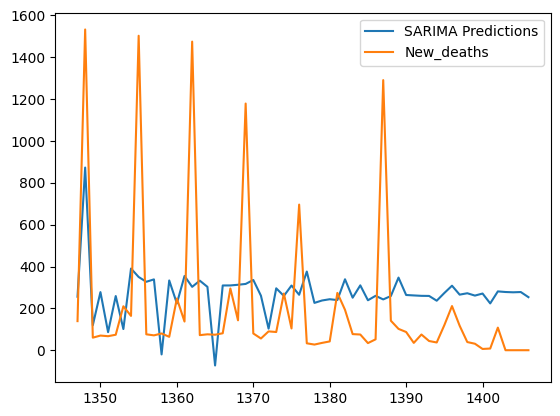

In [7]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('SARIMA Predictions')
pred.plot(legend=True)
test[target_column].plot(legend=True)

RMSE of the result

In [8]:
test[target_column].mean()
rmse=sqrt(mean_squared_error(pred,test[target_column]))
print(rmse)

349.2781837356974
